# Fireball
Agent based models on a free for all dogeball game.

Fireball is best described as a free for all dogeball game. 
In life, dodgeballs are set in the middle and every player starts on the edge. From there everyone plays against eachother with no alloted teams. When, you are eliminated, you stay out until the person who eliminated you gets out. Finally, the winner is determined by whoever has the most people out by the time limit.

Here is an implementation of our actor class.

In [3]:
import random
import numpy as np # seed set for reproducibility
np.random.seed(15)

# Main Actor Class
# Created by Ryan Bertola | March 24th 2024
class Actor():
    # initialization of class
    def __init__(self) -> None:
        self.downedBy = None # The player who eliminated this player. If None, player still in play
        self.downs = [] # The players this player has eliminated. If this player is downed,
        self.priority = 1 # Higher priority = targets first. 
        self.type = "" # Defined by a class if their type is actually relevant [aggressive has it defined bc aggressive targets aggressive]
        self.occupied = False # Mark as true if the player has been targetted. This is reset to false after the fight.
        self.target = None # The player this player is targetting [if they are targetting anybody]
        self.win_weight = 50 # The relative chance of winning against another player. DOES NOT NEED TO ADD TO 100.

    # Defines what gets printed when the actor has won. Must be defined for each strategy.
    def __str__(self):
        return "ERROR!!!!\nERROR!!!!\nERROR!!!!\nUnderdefined Actor [define a __str__ function for this class]"

    # target choosing, individually defined by each class
    def choose_target(self, targets):
        pass

    # what to do when the user is downed. Universally defined. 
    # Only edit this on a given class if they do something when downed [such as either cheating, holding a grudge, etc]
    # typically, try to super this rather than fully re-implementing.
    def downed(self, winner):
        self.downedBy = winner
        winner.downs.append(self)
        for d in self.downs:
            d.downedBy = None
        self.downs = []

    # what to do when battling. Universally defined. Do not edit on a per-class basis; this is meant to be global.
    def battle_target(self):
        self.on_battle()
        weights = [self.win_weight, self.target.win_weight]
        players = [self, self.target]
        winner = random.choices(players, weights)[0] # Determine winner base on weights. Higher weight = better odds
        if players[0] != winner:
            players[0].downed(winner)
        else:
            players[1].downed(winner)
        # Reset data
        self.occupied = False
        self.target.occupied = False
        self.target = None

    # if you wish for something to occur when the strategy battles, PLEASE make an altered verion of this instead. 
    # For example, if you want win rate to decrement with each fight.
    def on_battle(self):
        pass

# Strategy types
For fireball we considered a few strategy types for the games based on how people would act in life.
The two main strategies are Aggressive: A player that is more likely to engage and targets other aggressive players; and Passive: a player that prefers to not be involved in rounds and is less likely to engage. 
These two strategies will be the basis for many other strategies.
Other strategies include: RandomStrategy, WinnerTargeting, snake, knight, bestfriend etc.

# Passive Strategy

In [24]:
# Passive Actor Class
# Ryan Bertola | March 24th 2024
# Treated as the template for all other actors
class Passive(Actor):
    def __init__(self) -> None:
        super().__init__()
        self.type = "Passive"
        self.win_weight = 40 # Lower win weight to represent more battle experience
    
    def __str__(self):
        return "Passive"
    
    def choose_target(self, targets):
        return super().choose_target(targets)

# Aggressive Strategy

In [25]:
# Aggressive Actor Class
# Ryan Bertola | March 24th 2024
# Treated as the template for all other actors
class Aggressive(Actor):
    def __init__(self) -> None:
        super().__init__()
        self.type = "Aggressive"
        self.win_weight = 60 # Higher win weight to represent more battle experience
    
    def __str__(self):
        return "Aggressive"

    def choose_target(self, targets):
        # Filter targets down to the desired group
        if self.occupied:
            self.target = None
            return
        filteredTargets = [t for t in targets if t.type == "Aggressive" and t.occupied is False and t.downedBy is None]
        random.shuffle(filteredTargets)
        if len(filteredTargets) != 0:
            self.target = filteredTargets[0] # Set target to the first of the randomly shuffled group
        else:
            # Settle for any target if not desired group
            refiltered = [t for t in targets if t.occupied is False and t.downedBy is None]
            random.shuffle(refiltered)
            if len(refiltered) != 0:
                self.target = refiltered[0]
            else: # If no unoccupied players or non-downed players are found, default to no target.
                self.target = None
        if self.target is not None:
            self.target.occupied = True
        

As seen in the choose target method, targets are checked if they are aggressive or not, if they are they are going to be targeted by the aggressive actor. If the aggressive actor does not find any other aggressive actors they settle for anything else.

# Game Implementation
A game class is created seperately so we can run multiple games without data leaks.

In [28]:
import time
from matplotlib import pyplot as plt
import utils


# The game class, to store all game data.
class Game:
    # define any variables you wish to track here
    def __init__(self, players: list[Actor], end: int = 500) -> None:
        self.playerlist = players  # player list
        self.end = end  # the round in which the end occurs [default 500]
        self.iteration = 0  # which round we are at [if iteration > end, end round]
        self.down_count = []
        pass

    # iterates the game a given amount of count [default 500]
    def iterate(self, count=500):
        for i in range(count):
            self.iteration += 1
            self.data_collection()
            self.game_logic()
            downedPlayers = [i for i in self.playerlist if i.downedBy is not None]
            self.down_count.append(len(downedPlayers))
            # check if game ended.
            if self.iteration >= self.end:
                self.end_game()
                break

    # Ends the game. Any data that needs to be outputted should be put here.
    def end_game(self):
        plt.plot(self.down_count)
        plt.xlabel("Round number")
        plt.ylabel("Players downed")
        plt.show()
        finalLeaderboard = sorted(self.playerlist, key=lambda x: len(x.downs), reverse=True)
        winner = finalLeaderboard[0]
        print(f"An {winner} strategy has won with {len(winner.downs)} downs!")

    # Outputs data at the given moment
    def get_game_data(self):
        leaderboard = sorted(self.playerlist, key=lambda x: len(x.downs), reverse=True)
        current_winner = leaderboard[0]
        print(f"A(n) {current_winner} strategy is winning with {len(current_winner.downs)} downs!")
        downedPlayers = [i for i in self.playerlist if i.downedBy is not None]
        print(f"There are {len(downedPlayers)} downed players.")
        # time.sleep(10) # 10-second delay to give time to read. Can be edited.

    def data_collection(self):
        if self.iteration >= self.end:  # Announce final round
            print("Final round!")
        if not self.iteration % 100 and self.iteration < self.end:
            self.get_game_data()
            rawDownData = self.get_downed_each()
            print(rawDownData)
        print(f"Round {self.iteration} has commenced!")

    def game_logic(self):  # Run the game logic
        random.shuffle(self.playerlist)  # Shuffle player list
        self.playerlist.sort(key=lambda x: x.priority, reverse=True)  # Sort by priority
        for p in self.playerlist:
            p.choose_target(self.playerlist)  # Targetting logic
        for p in [n for n in self.playerlist if n.target is not None]:
            p.battle_target()  # Battling logic

    def get_downed_each(self):  # Get stats on how much of each class is downed
        playerTypes = list(set([i.type for i in self.playerlist]))  # Get each type of player in game
        downedPlayers = [p.type for p in self.playerlist if p.downedBy is not None]  # Get downed player types
        eachDowned = {}
        for t in playerTypes:
            eachDowned[t] = downedPlayers.count(t)  # With the set-up made above, counting is simple :D
        return eachDowned  # A dictionary of each class and how much is downed
    
    def getscore(self):
        #doyin addition
        """
        Sets the final leader board score to remove repitition,
        send leaderboard and current game scoreboard to parse and allocate points,
        
        """
        finalLeaderboard = sorted(self.playerlist, key=lambda x: len(x.downs), reverse=True)
        unique_types = set()
        unique_score = []
        playerTypes = list(set([i.type for i in self.playerlist])) 
        scoreboard = {}
        for p in finalLeaderboard:
            if p.type not in unique_types:
                unique_score.append(p.type)
                unique_types.add(p.type)
        for t in playerTypes:
            scoreboard[t] = 0
        return unique_score, scoreboard

# Aggressive vs Passive Game simulation

Round 1 has commenced!
Round 2 has commenced!
Round 3 has commenced!
Round 4 has commenced!
Round 5 has commenced!
Round 6 has commenced!
Round 7 has commenced!
Round 8 has commenced!
Round 9 has commenced!
Round 10 has commenced!
Round 11 has commenced!
Round 12 has commenced!
Round 13 has commenced!
Round 14 has commenced!
Round 15 has commenced!
Round 16 has commenced!
Round 17 has commenced!
Round 18 has commenced!
Round 19 has commenced!
Round 20 has commenced!
Round 21 has commenced!
Round 22 has commenced!
Round 23 has commenced!
Round 24 has commenced!
Round 25 has commenced!
Round 26 has commenced!
Round 27 has commenced!
Round 28 has commenced!
Round 29 has commenced!
Round 30 has commenced!
Round 31 has commenced!
Round 32 has commenced!
Round 33 has commenced!
Round 34 has commenced!
Round 35 has commenced!
Round 36 has commenced!
Round 37 has commenced!
Round 38 has commenced!
Round 39 has commenced!
Round 40 has commenced!
Round 41 has commenced!
Round 42 has commenced!
R

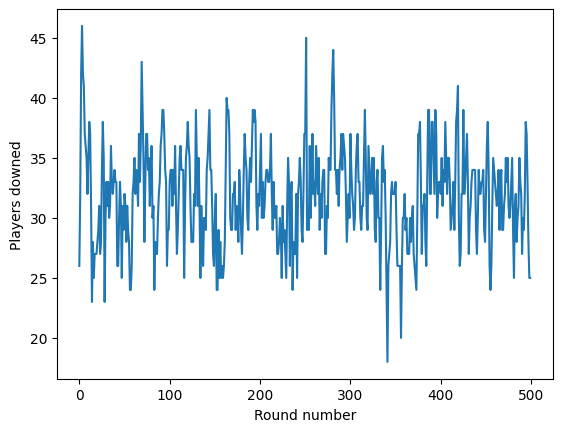

An Aggressive strategy has won with 5 downs!


In [57]:


firstList = [Aggressive() for i in range(50)] + [Passive() for j in range(50)]
firstGame = Game(firstList)
firstGame.iterate()
#When the game ends the winner of the 500th round is announced

For one game of Fireball between 50 aggressive and 50 passive players
the peak amount of players down occcured during the middle of each hundreth round and the lows occured closer to the beginning of the next hundreth

# Scoring
Finally we can check the scoreboard and allot points using a golf style system where the winner is the strategy with the least amount of points.

In [58]:
roundscore, scoreboard = firstGame.getscore()
Leaderboard = scoreboard

for i, t in enumerate(roundscore):
    Leaderboard[t] += i + 1
print(roundscore, Leaderboard)

['Aggressive', 'Passive'] {'Aggressive': 1, 'Passive': 2}


And obviously as seen before aggressive won so it would have 1 point while passive has 2

# The Game
Fireball has 8 more strategies <br>
Knight: An actor that does not target the actor with the highest amount of downs. <br>
Besties: Two actors who don't target eachother until they are just left. <br>
Snake: A bestie who breaks the rule of not targeting until the end. <br>
Revenge: an actor who targets anyone that has downed them. <br>
Fuse: An actor who gets more chaotic the more they are downed. <br>
Winner Targetting: an actor who targets actors with 4+ downs. <br>
Random: an actor who targets at random. <br>
Merciless: An actor who targets other with the least amount of downs. <br>
Now that you know all the strategies test out some game configurations and track some stats.

In [39]:
# Knight Actor Class
# Ryan Bertola | April 20th 2024
# Will target anyone except those they deem the winner. Only activates when somebody has >2 downs.
class Knight(Actor):
    def __init__(self) -> None:
        super().__init__()
        self.type = "Knight"
    
    def __str__(self):
        return "Knight"

    def choose_target(self, targets):
        # Filter targets down to the desired group
        if self.occupied:
            self.target = None
            return
        filteredTargets = [t for t in targets if t.occupied is False and t.downedBy is None] # Removes downed / occupied players.
        filteredTargets.sort(key=lambda x: len(x.downs), reverse=True) # Sorts by downs in descending order
        if len(filteredTargets) != 0 and len(filteredTargets[0].downs) >= 2: # Ensures 2 downs.
            leaderDowns = len(filteredTargets[0].downs)
            filteredTargets = [t for t in filteredTargets if len(t.downs) == leaderDowns] # Removes any user who is in the lead [to prevent complications if there is a current tie].
            self.target = random.choice(filteredTargets) # Selects random target
        else:
            self.target = None # Does not target anyone otherwise.
        if self.target is not None:
            self.target.occupied = True

# Besties Actor Class
# Ryan Bertola | April 20th 2024
# Strategy by Doyin. Two are created at a time. 
# They refuse to target eachother unless they are the only option.
# If bestie is downed, will target the player who downed bestie.
class Bestie(Actor):
    def __init__(self, friend) -> None:
        super().__init__()
        self.type = "Bestie"
        self.friend = friend
    
    def __str__(self):
        return "Bestie"

    def choose_target(self, targets):
        # Filter targets down to the desired group
        if self.occupied:
            self.target = None
            return
        if self.friend.downedBy is not None and not self.friend.downedBy.occupied: # If friend downed and downer is not occupied, target downer
            self.target = self.friend.downedBy
        filteredTargets = [t for t in targets if t.occupied is False and t.downedBy is None and t != self.friend] # Removing friend and invalid targets
        random.shuffle(filteredTargets)
        if len(filteredTargets) != 0:
            self.target = filteredTargets[0] # Set target to the first of the randomly shuffled group
        else:
            # Settle for any target if not desired group, typically meaning friend, but not exclusively to account for unseen edgecases. Can never be too safe.
            refiltered = [t for t in targets if t.occupied is False and t.downedBy is None]
            random.shuffle(refiltered)
            if len(refiltered) != 0:
                self.target = refiltered[0]
            else: # If no unoccupied players or non-downed players are found, default to no target.
                self.target = None
        if self.target is not None:
            self.target.occupied = True

# Function to create besties due to the complexities of such.
# Should be used in any situation where besties are made.
# Returns a list of two besties who have eachother as their friend.
def createBesties():
    f1 = Bestie(None)
    f2 = Bestie(f1)
    f1.friend = f2
    return [f1, f2]

# Snake Actor Class
# Ryan Bertola | April 20th 2024
# Strategy by Doyin. Snake will act like a bestie until a random moment.
# Random moment is a 1/100 to occur on a given time they choose target.
class Snake(Actor):
    def __init__(self, friend) -> None:
        super().__init__()
        self.type = "Snake"
        self.friend = friend
        self.broken = False
    
    def __str__(self):
        return "Snake"

    def choose_target(self, targets):
        # Filter targets down to the desired group
        if self.occupied:
            self.target = None
            return
        if self.friend.downedBy is not None and not self.friend.downedBy.occupied and not self.broken: # If friend downed and downer is not occupied, target downer
            self.target = self.friend.downedBy
        if random.randrange(100) == 42: # 1/100 chance to break the bond at any moment. Friend does not realize, and will think it's a mistake.
            self.broken = True
        if not self.broken:
            filteredTargets = [t for t in targets if t.occupied is False and t.downedBy is None and t != self.friend] # Removing friend and invalid targets
        else:
            filteredTargets = [t for t in targets if t.occupied is False and t.downedBy is None] # Removing only invalid targets instead
        random.shuffle(filteredTargets)
        if len(filteredTargets) != 0:
            self.target = filteredTargets[0] # Set target to the first of the randomly shuffled group
        else:
            # Settle for any target if not desired group, typically meaning friend, but not exclusively to account for unseen edgecases. Can never be too safe.
            refiltered = [t for t in targets if t.occupied is False and t.downedBy is None]
            random.shuffle(refiltered)
            if len(refiltered) != 0:
                self.target = refiltered[0]
            else: # If no unoccupied players or non-downed players are found, default to no target.
                self.target = None
        if self.target is not None:
            self.target.occupied = True


# Function to create snake and bestie due to the complexities of such.
# Should be used in any situation where a snake is made.
# Returns a list of a snake and a bestie who have eachother as their friend.
def createSnake():
    f1 = Snake(None)
    f2 = Bestie(f1)
    f1.friend = f2
    return [f1, f2]

# Revenge Actor Class
# Ryan Bertola | April 20th 2024
# Idea by Doyin
# Targets randomly until downed twice by same person. Then, will target them above all else
class Revenge(Actor):
    def __init__(self) -> None:
        super().__init__()
        self.type = "Revenge"
        self.prevDowns = []
    
    def __str__(self):
        return "Revenge"

    def choose_target(self, targets):
        # Filter targets down to the desired group
        if self.occupied:
            self.target = None
            return
        enemy = self.determine_enemy()
        if enemy is not None and enemy.downedBy is None and not enemy.occupied: # Ensures enemy can be selected
            self.target = enemy
        else:
            filteredTargets = random.shuffle([t for t in targets if t.occupied is False and t.downedBy is None]) # Removes downed / occupied players.
            if filteredTargets is not None and len(filteredTargets) != 0:
                self.target = filteredTargets[0]
            else:
                self.target = None # Does not target anyone otherwise.
        if self.target is not None:
            self.target.occupied = True
    
    def downed(self, winner): # Adding to list of prevdowns
        self.prevDowns.append(winner)
        return super().downed(winner) # Reusing existent code to minimize rewritten code
    
    def determine_enemy(self):
        uniquePast = random.shuffle(list(set(self.prevDowns))) # remove dupes and randomly order them
        if uniquePast is None: # If no past
            return None
        downedByEach = [[self.prevDowns.count(i), i] for i in uniquePast] # Count previous downs from each
        downedByEach.sort(key=lambda x: x[0], reverse=True) # Get descending order
        if downedByEach[0][0] >= 2:
            revengePoint = downedByEach[0][0] # Determine how many downs on this user are needed to be considered a possible enemy
            possibleEnemies = random.shuffle([i for i in downedByEach if i[0] >= revengePoint]) # remove all lower than the revenge point and randomly shuffle them
            return possibleEnemies[0][1] # Select the enemy
        return None # If this point is reached, no enemy is selected. Thus, random selection will begin.

# Fuse Actor Class
# Ryan Bertola | April 20th 2024
# Idea by Doyin
# Passive first 10 downs
# Aggressive next 20
# Random forever after
class Fuse(Actor):
    def __init__(self) -> None:
        super().__init__()
        self.type = "Fuse"
        self.prevDowns = []
    
    def __str__(self):
        return "Fuse"

    def choose_target(self, targets):
        if len(self.prevDowns) < 10: # Passive
            return super().choose_target(targets)
        elif len(self.prevDowns) < 30: # Aggressive
            # Filter targets down to the desired group
            if self.occupied:
                self.target = None
                return
            filteredTargets = [t for t in targets if t.type == "Aggressive" and t.occupied is False and t.downedBy is None]
            random.shuffle(filteredTargets)
            if len(filteredTargets) != 0:
                self.target = filteredTargets[0] # Set target to the first of the randomly shuffled group
            else:
                # Settle for any target if not desired group
                refiltered = [t for t in targets if t.occupied is False and t.downedBy is None]
                random.shuffle(refiltered)
                if len(refiltered) != 0:
                    self.target = refiltered[0]
                else: # If no unoccupied players or non-downed players are found, default to no target.
                    self.target = None
        else: # Random
            # Filter targets down to the desired group
            if self.occupied:
                self.target = None
                return
            filteredTargets = [t for t in targets if t.occupied is False and t.downedBy is None] # Remove occupied and downed players.
            random.shuffle(filteredTargets)
            if len(filteredTargets) != 0:
                self.target = filteredTargets[0] # Set target to the first of the randomly shuffled group
            else:
                self.target = None # If nobody is available we don't want them to target
        if self.target is not None:
            self.target.occupied = True
    
    def downed(self, winner): # Adding to list of prevdowns
        self.prevDowns.append(winner)
        return super().downed(winner) # Reusing existent code to minimize rewritten code


# WinTarg Actor Class
# Ryan Bertola | April 20th 2024
# Will target exclusively those they deem the winner. Only activates when somebody has >4 downs.
class WinTarg(Actor):
    def __init__(self) -> None:
        super().__init__()
        self.type = "Winner Targetting"
        self.priority = 2  # Higher priority means the winner doesn't get a chance to target somebody else.

    def __str__(self):
        return "Winner Targetting"

    def choose_target(self, targets):
        # Filter targets down to the desired group
        if self.occupied:
            self.target = None
            return
        filteredTargets = [t for t in targets if
                           t.occupied is False and t.downedBy is None]  # Removes downed / occupied players.
        filteredTargets.sort(key=lambda x: len(x.downs), reverse=True)  # Sorts by downs in descending order
        if len(filteredTargets) != 0 and len(filteredTargets[0].downs) >= 5:  # Ensures 5 downs.
            self.target = filteredTargets[0]  # Set target to the leader
        else:
            self.target = None  # Does not target anyone otherwise.
        if self.target is not None:
            self.target.occupied = True

# RandomStrat Actor Class
# Ryan Bertola | April 20th 2024
# A strategy with no strategy. Just random.
# This class is not named random so as to not interfere with the existent random library.
class RandomStrat(Actor):
    def __init__(self) -> None:
        super().__init__()
        self.type = "Random"
    
    def __str__(self):
        return "Random"

    def choose_target(self, targets):
        # Filter targets down to the desired group
        if self.occupied:
            self.target = None
            return
        filteredTargets = [t for t in targets if t.occupied is False and t.downedBy is None] # Remove occupied and downed players.
        random.shuffle(filteredTargets)
        if len(filteredTargets) != 0:
            self.target = filteredTargets[0] # Set target to the first of the randomly shuffled group
        else:
            self.target = None # If nobody is available we don't want them to target
        if self.target is not None:
            self.target.occupied = True
        
# Merciless Actor Class
# Ryan Bertola | April 20th 2024
# Will only target those who have less than 2 downs if possible. Otherwise, randomly targets.
# Originally referred to as "Tryhard" but sounded too biased [regardless of us having no bias when making these strategies]
class Merciless(Actor):
    def __init__(self) -> None:
        super().__init__()
        self.type = "Merciless"
    
    def __str__(self):
        return "Merciless"

    def choose_target(self, targets):
        # Filter targets down to the desired group
        if self.occupied:
            self.target = None
            return
        filteredTargets = [t for t in targets if t.occupied is False and t.downedBy is None and len(t.downs) <= 2] # Removes downed / occupied players and players with more than 2 downs
        if len(filteredTargets) != 0: # Player with less than two downs found
            self.target = random.choice(filteredTargets) # Selects random target
        else: # Random time
            filteredTargets = [t for t in targets if t.occupied is False and t.downedBy is None] # Remove occupied and downed players.
            random.shuffle(filteredTargets)
            if len(filteredTargets) != 0:
                self.target = filteredTargets[0] # Set target to the first of the randomly shuffled group
            else:
                self.target = None # If nobody is available we don't want them to target.
        if self.target is not None:
            self.target.occupied = True

# A 3 Game FFA of Every Strategy
To start off 10 actors of each strategy will fare of against each other for 3 different games. <br>
The total will be tallied and the best strategy will be shown at the end.

Round 1 has commenced!
Round 2 has commenced!
Round 3 has commenced!
Round 4 has commenced!
Round 5 has commenced!
Round 6 has commenced!
Round 7 has commenced!
Round 8 has commenced!
Round 9 has commenced!
Round 10 has commenced!
Round 11 has commenced!
Round 12 has commenced!
Round 13 has commenced!
Round 14 has commenced!
Round 15 has commenced!
Round 16 has commenced!
Round 17 has commenced!
Round 18 has commenced!
Round 19 has commenced!
Round 20 has commenced!
Round 21 has commenced!
Round 22 has commenced!
Round 23 has commenced!
Round 24 has commenced!
Round 25 has commenced!
Round 26 has commenced!
Round 27 has commenced!
Round 28 has commenced!
Round 29 has commenced!
Round 30 has commenced!
Round 31 has commenced!
Round 32 has commenced!
Round 33 has commenced!
Round 34 has commenced!
Round 35 has commenced!
Round 36 has commenced!
Round 37 has commenced!
Round 38 has commenced!
Round 39 has commenced!
Round 40 has commenced!
Round 41 has commenced!
Round 42 has commenced!
R

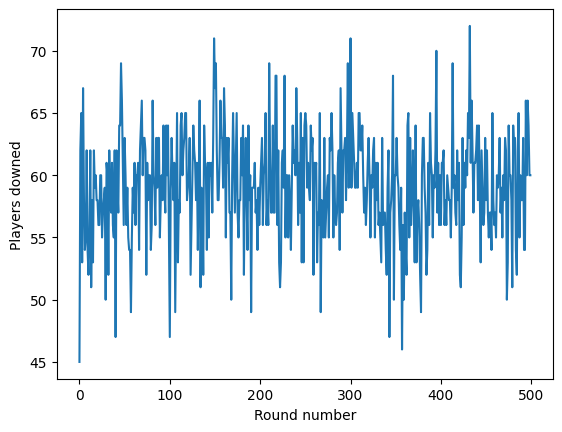

An Merciless strategy has won with 7 downs!
['Merciless', 'Snake', 'Fuse', 'Winner Targetting', 'Knight', 'Revenge', 'Bestie', 'Passive', 'Aggressive', 'Random']


In [74]:
#For besties and snakes since they create pairs this is how they will be used to add to a list
Durants = []
for x in range(10):
  Durants += createSnake()

bestiesList = []
for y in range(10):
  bestiesList += createBesties()


GList = ([Aggressive() for i in range(10)] + [Revenge() for j in range(10)]
            + [RandomStrat() for k in range(10)] + bestiesList 
            + [Knight() for i in range(10)] + Durants
            + [Fuse() for j in range(10)] + [Merciless() for k in range(10)]  
            + [Passive() for k in range(10)] + [WinTarg() for k in range(10)]
            )
firstGame = Game(GList)
firstGame.iterate()

roundscore, scoreboard = firstGame.getscore()
Leaderboard = scoreboard
#IMPORTANT, you set leaderboard to scoreboard here because you don't want to change scoreboard each iteration

for i, t in enumerate(roundscore): #This allocates the points to the appropriate strategy
    Leaderboard[t] += i + 1

print(roundscore) #tells you how much each strategy was downed

Round 1 has commenced!
Round 2 has commenced!
Round 3 has commenced!
Round 4 has commenced!
Round 5 has commenced!
Round 6 has commenced!
Round 7 has commenced!
Round 8 has commenced!
Round 9 has commenced!
Round 10 has commenced!
Round 11 has commenced!
Round 12 has commenced!
Round 13 has commenced!
Round 14 has commenced!
Round 15 has commenced!
Round 16 has commenced!
Round 17 has commenced!
Round 18 has commenced!
Round 19 has commenced!
Round 20 has commenced!
Round 21 has commenced!
Round 22 has commenced!
Round 23 has commenced!
Round 24 has commenced!
Round 25 has commenced!
Round 26 has commenced!
Round 27 has commenced!
Round 28 has commenced!
Round 29 has commenced!
Round 30 has commenced!
Round 31 has commenced!
Round 32 has commenced!
Round 33 has commenced!
Round 34 has commenced!
Round 35 has commenced!
Round 36 has commenced!
Round 37 has commenced!
Round 38 has commenced!
Round 39 has commenced!
Round 40 has commenced!
Round 41 has commenced!
Round 42 has commenced!
R

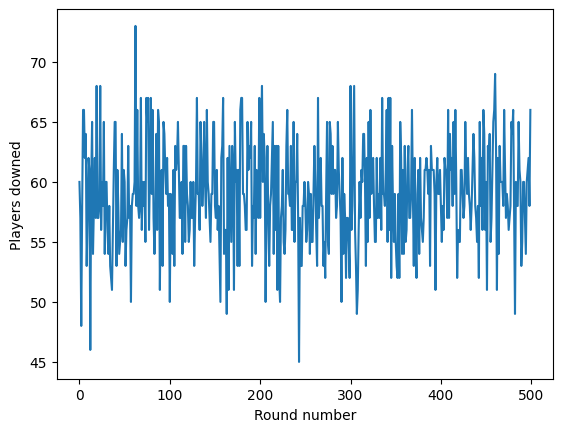

An Aggressive strategy has won with 8 downs!
['Aggressive', 'Knight', 'Snake', 'Random', 'Revenge', 'Bestie', 'Merciless', 'Fuse', 'Winner Targetting', 'Passive']


In [75]:
SecondGame = Game(GList)
SecondGame.iterate()
# A new graph per game

roundscore, scoreboard = SecondGame.getscore()
for i, t in enumerate(roundscore):
    Leaderboard[t] += i + 1

print(roundscore)

Round 1 has commenced!
Round 2 has commenced!
Round 3 has commenced!
Round 4 has commenced!
Round 5 has commenced!
Round 6 has commenced!
Round 7 has commenced!
Round 8 has commenced!
Round 9 has commenced!
Round 10 has commenced!
Round 11 has commenced!
Round 12 has commenced!
Round 13 has commenced!
Round 14 has commenced!
Round 15 has commenced!
Round 16 has commenced!
Round 17 has commenced!
Round 18 has commenced!
Round 19 has commenced!
Round 20 has commenced!
Round 21 has commenced!
Round 22 has commenced!
Round 23 has commenced!
Round 24 has commenced!
Round 25 has commenced!
Round 26 has commenced!
Round 27 has commenced!
Round 28 has commenced!
Round 29 has commenced!
Round 30 has commenced!
Round 31 has commenced!
Round 32 has commenced!
Round 33 has commenced!
Round 34 has commenced!
Round 35 has commenced!
Round 36 has commenced!
Round 37 has commenced!
Round 38 has commenced!
Round 39 has commenced!
Round 40 has commenced!
Round 41 has commenced!
Round 42 has commenced!
R

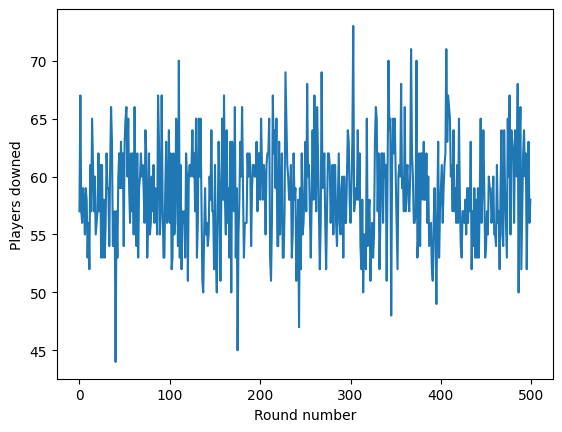

An Winner Targetting strategy has won with 6 downs!
['Winner Targetting', 'Bestie', 'Fuse', 'Snake', 'Revenge', 'Merciless', 'Random', 'Aggressive', 'Knight', 'Passive']


In [76]:
ThirdGame = Game(GList)
ThirdGame.iterate()

roundscore, scoreboard = ThirdGame.getscore()
for i, t in enumerate(roundscore):
    Leaderboard[t] += i + 1

print(roundscore)

A Merciless, Aggressive and a winner Targetting strategy all won their ronds.
Lets see what the leader board has to say.

In [77]:
print(Leaderboard)

{'Fuse': 14, 'Snake': 9, 'Revenge': 16, 'Passive': 28, 'Knight': 16, 'Winner Targetting': 14, 'Aggressive': 18, 'Bestie': 15, 'Random': 21, 'Merciless': 14}


Interestingly enough, despite Merciless, Aggressive and Winner targetting winning each game. snake won and by far. This kind of makes sense as snake would be betting on someone else not attacking them while they are allowed to betray.

There are many combinations and variables you can configure. Try out different strategies against others.